In [1]:
using LinearAlgebra
using CairoMakie
using Latexify
using LaTeXStrings
using Colors
using Markdown
using Printf

# Purpose

$$
\def\dd#1#2{\frac{d #1}{d #2}}
\def\pd#1#2{\frac{\partial #1}{\partial #2}}
\def\R{\mathbf{R}}
\def\P{\mathbf{P}}
\def\t{\mathbf{t}}
\def\x{\mathbf{x}}
\def\y{\mathbf{y}}
\def\d{\mathrm{d}}
\def\D{\mathrm{D}}
\def\w#1{\mathbf{#1}^\wedge}
$$

Shiney toy: nice PDF on lie group derivatives. [https://arxiv.org/abs/1812.01537]

## Input

Set of 2d points $\x$ and $\y$ and covariances.  Points are already associated - (that's it's own problem).

## Ouput

$\mathbf{P}_{est}$, best registration estimate.  $\y \approx \mathbf{P}_{est} \x$.



# Displacement

$$\begin{align}
d_i(\P) & = \y_i - \P \x_i \\
\mathrm{d} d_i(\P) & = -\d(\P \x_i) \\
\end{align}$$


# Lie Derivative

## 2D Twist
$$\begin{align}
\w{\xi} &= \begin{pmatrix}
0 && -\omega && v_x \\
\omega && 0 && v_y \\
0 && 0 && 0 \\
\end{pmatrix} \\
\x &= \begin{pmatrix}
x \\
y \\
1 \\
\end{pmatrix} \\
\xi &= \begin{pmatrix}
v_x \\
v_y \\
\omega \\
\end{pmatrix} \\
\w{\xi} \x & = \begin{pmatrix}
-\omega y + v_x \\
\omega x + v_y \\
0 \\
\end{pmatrix} \\
\begin{pmatrix}
1 && 0 && -y  \\
0 && 1 && x \\
0 && 0 && 0 \\
\end{pmatrix} \xi &= \begin{pmatrix}
-\omega y + v_x \\
\omega x + v_y \\
0 \\
\end{pmatrix} \\
\x^\odot & = \begin{pmatrix}
1 && 0 && -y  \\
0 && 1 && x \\
0 && 0 && 0 \\
\end{pmatrix} \\
\end{align}$$

## Lie Derivative

$$\begin{align}
\frac{D \P \mathbf{x}}{D \P} &= \lim_{\xi \to 0} \frac{\P \exp(\xi) \x - \P \x}{\xi} \\
&= \lim_{\xi \to 0} \frac{\P (\mathbf{I} + \w{\xi}) \x - \P \x}{\xi} \\
&= \lim_{\xi \to 0} \frac{\P \x + \P \w{\xi} \x  - \P \x}{\xi} \\
&= \lim_{\xi \to 0} \frac{\P \w{\xi} \x}{\xi} \\
&= \lim_{\xi \to 0} \frac{\P \x^\odot \xi}{\xi} \\
&= \P \x^\odot \\
\end{align}$$

## Loss

Simple mahalanobis loss.  Assumes association already done.

$$\begin{align}
L & = \sum_i d_i(\P)^T \Lambda_i d_i(\P) \\
\d L & = \sum_i (\d d_i(\P))^T \Lambda_i d_i(\P) + d_i(\P)^T \Lambda_i \d d_i(\P)\\
& = 2 \sum_i d_i(\P)^T \Lambda_i \d d_i(\P) \\
\nabla_\xi L & = -2 \sum_i d_i(\P)^T \Lambda_i \P \x_i^\odot \\
\end{align}$$


# Algorithm

In [2]:
xodot(px)=[
    1 0 -px[2]
    0 1 px[1]
    0 0 0
]
hat(ξ) = [
    0 -ξ[3] ξ[1]
    ξ[3] 0  ξ[2]
    0 0 0
]

@Base.kwdef mutable struct Results
    P_est::Matrix{Float64} = I(3)
    history::Vector{Matrix{Float64}} = Vector{Matrix{Float64}}()
    loss_history::Vector{Float64} = Vector{Float64}()
    iterations::Int
end

get_rot(mat::Matrix) = atan(mat[2,1], mat[1,1])

"""
2d SE(2) Registration gradient descent.
"""
function se2_registration_gd(x, y, Σs; α=.0001, iterations=10_000)
    rv = Results(iterations=iterations)
    Λs = [inv(Σ) for Σ ∈ Σs]
    for _ ∈ 1:iterations
        ∇L = zeros(1, 3)
        loss = 0
        for (px, py, Λ) ∈ zip(eachcol(x), eachcol(y), Λs)
            r = py - rv.P_est * px
            J = rv.P_est * xodot(px)
            
            ∇L += -2 * r' * Λ * J
            loss += r' * Λ * r
        end
        
        push!(rv.history, copy(rv.P_est))
        push!(rv.loss_history, loss)
        rv.P_est = rv.P_est * exp(hat(-α * ∇L))
    end
    return rv
end

"""
2d SE(2) Registration Levenberg Marquardt.
"""
function se2_registration_lm(x, y, Σs; λ0=1e-3, iterations=10_000, λ_up = 10.0, λ_down = .1)
    rv = Results(iterations=iterations)
    Λs = [inv(Σ) for Σ ∈ Σs]
    λ = λ0
    for _ ∈ 1:iterations
        ∇L = zeros(1, 3)
        H = zeros(3, 3)
        loss = 0
        for (px, py, Λ) ∈ zip(eachcol(x), eachcol(y), Λs)
            r = py - rv.P_est * px
            J = rv.P_est * xodot(px)
            
            ∇L += r' * Λ * J
            H += J' * Λ * J
            loss += r' * Λ * r
        end
        
        H += λ * I(3)
        δξ = H \ ∇L'
        P_trial = rv.P_est * exp(hat(δξ))
        trial_loss = 0.0
        for (px, py, Λ) ∈ zip(eachcol(x), eachcol(y), Λs)
            r = py - P_trial * px
            trial_loss += r' * Λ * r
        end

        if trial_loss < loss
            rv.P_est = rv.P_est * exp(hat(δξ))
            loss = trial_loss
            λ *= λ_down
        else
            λ *= λ_up
        end
        push!(rv.history, copy(rv.P_est))
        push!(rv.loss_history, loss)
    end
    return rv
end

se2_registration_lm

# Test

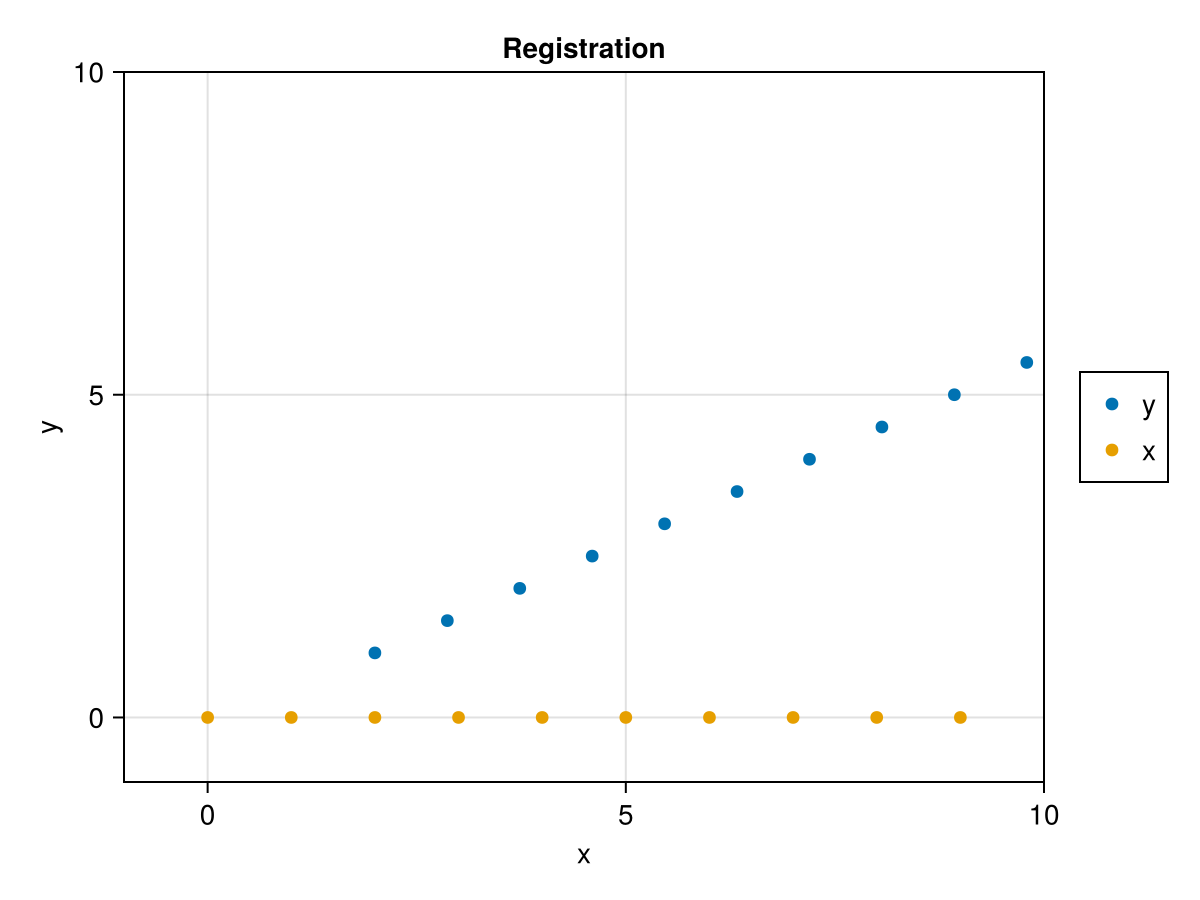

In [3]:
x = [collect(0:9) fill(0, 10) fill(1, 10)]'

R(θ) = [
    cos(θ) -sin(θ)
    sin(θ) cos(θ)
]

# Ground Truth - 30 °, and [2,1] translation.
θ_GT = deg2rad(30) 
t_GT = [2, 1]
P_GT = [
    R(θ_GT)  t_GT
    0 0 1
]
y = P_GT * x

Σs = fill([
    2 * I(2) [0,0]
    0 0 1
], length(x))

f = Figure()
ax = Axis(f[1,1], title="Registration", xlabel="x", ylabel="y")
plt_y = scatter!(ax, y[1,:], y[2,:])
plt_x = scatter!(ax, x[1,:], x[2,:])
xlims!(-1, 10)
ylims!(-1, 10)
Legend(f[1,2], [plt_y, plt_x], ["y", "x"])
f

# Gradient Descent

| Param |        θ |              t |
| -----:| --------:| --------------:|
|    GT | 30.000 ° | [2.000, 1.000] |
|   Est | 29.653 ° | [1.968, 1.026] |


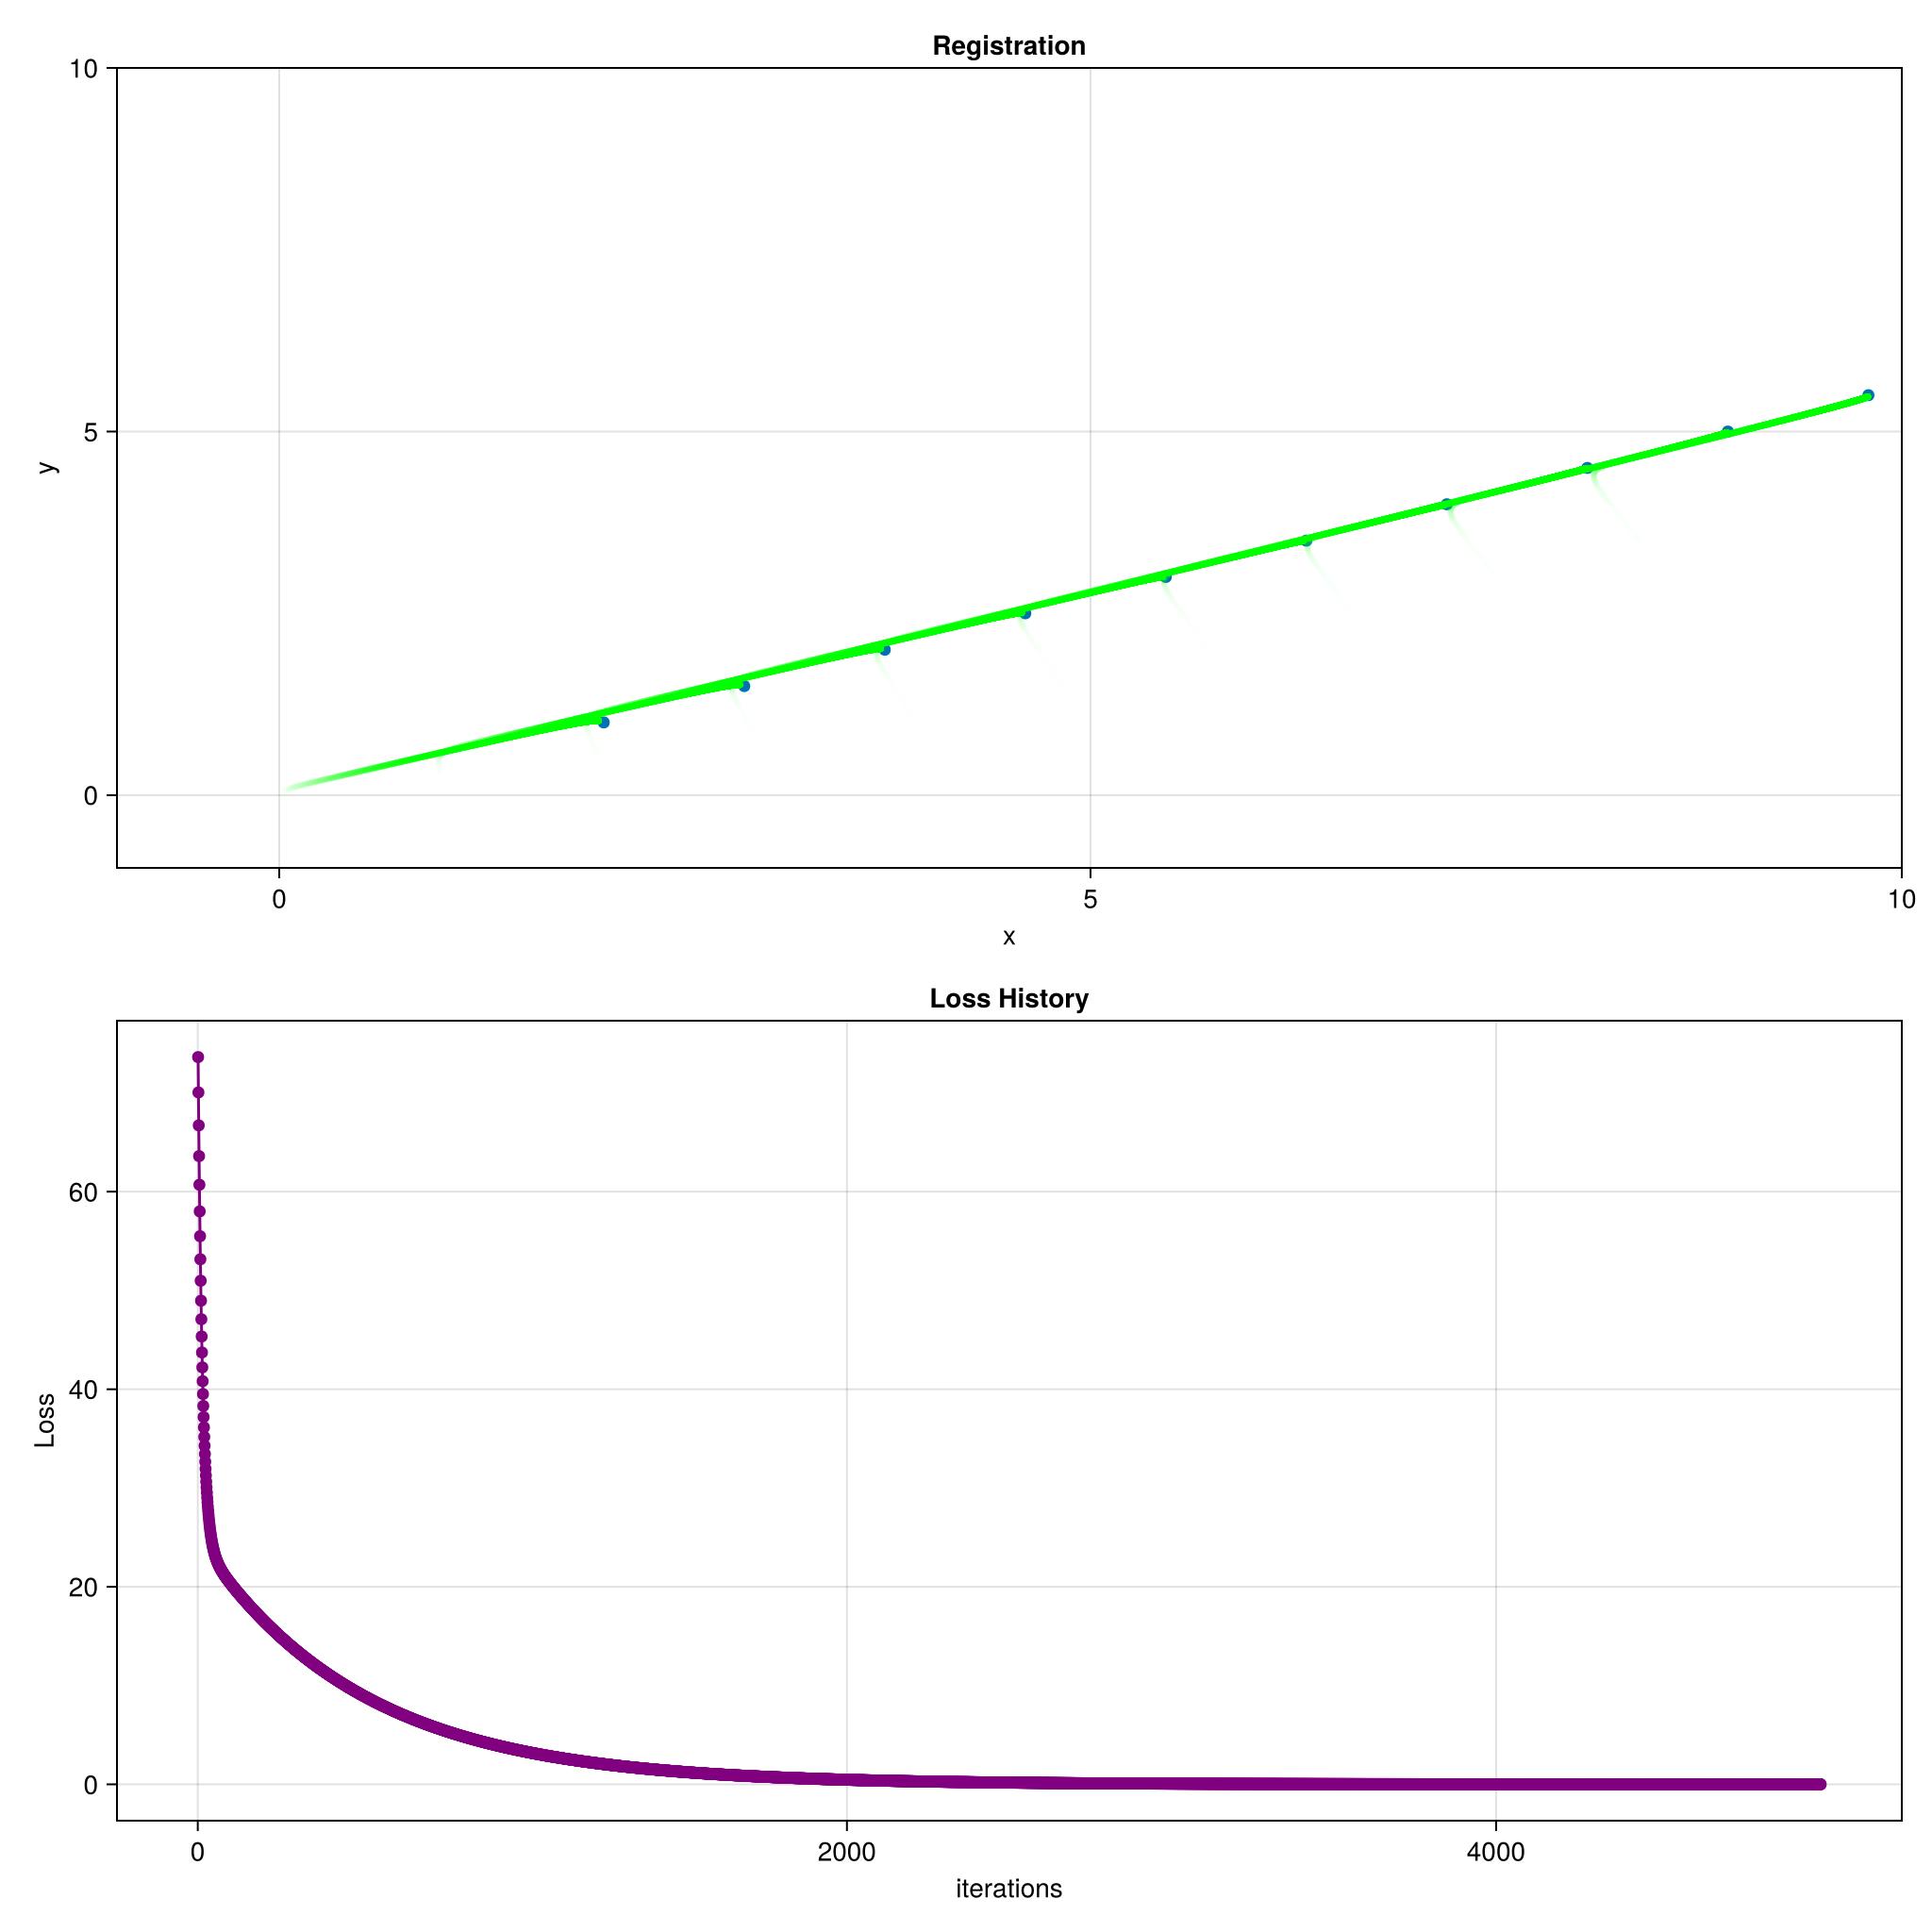

In [4]:
results = se2_registration_gd(x, y, Σs; iterations=5_000)

θ_GT_str = @sprintf("%.3f", rad2deg(θ_GT))
t_GT_str = "[" * join((@sprintf("%.3f", i) for i in t_GT), ", ") * "]"
θ_est_str = @sprintf("%.3f", rad2deg(get_rot(results.P_est)))
t_est_str = "[" * join((@sprintf("%.3f", i) for i in results.P_est[1:2,3]), ", ") * "]"
display(md"""
| Param | θ              | t              |
| ----- | -------------- | -------------- |
| GT    | $(θ_GT_str) °  | $(t_GT_str)    |
| Est   | $(θ_est_str) ° | $(t_est_str)   |
""")

f = Figure(;size=(1024, 1024))
ax = Axis(f[1,1], title="Registration", xlabel="x", ylabel="y")
scatter!(ax, y[1,:], y[2,:])
for (i, P) ∈ enumerate(results.history)
    x_est = P * x
    α = i / results.iterations
    scatter!(
        ax, 
        x_est[1,:], x_est[2,:],
        color=RGBA(0, 1, 0, α),
        markersize = 5
    )
end
xlims!(-1, 10)
ylims!(-1, 10)

ax = Axis(f[2,1], title="Loss History", xlabel="iterations", ylabel="Loss")
scatterlines!(ax, results.loss_history, color = :purple)
f

# Levenberg-Marquardt

| Param |        θ |              t |
| -----:| --------:| --------------:|
|    GT | 30.000 ° | [2.000, 1.000] |
|   Est | 30.000 ° | [2.000, 1.000] |


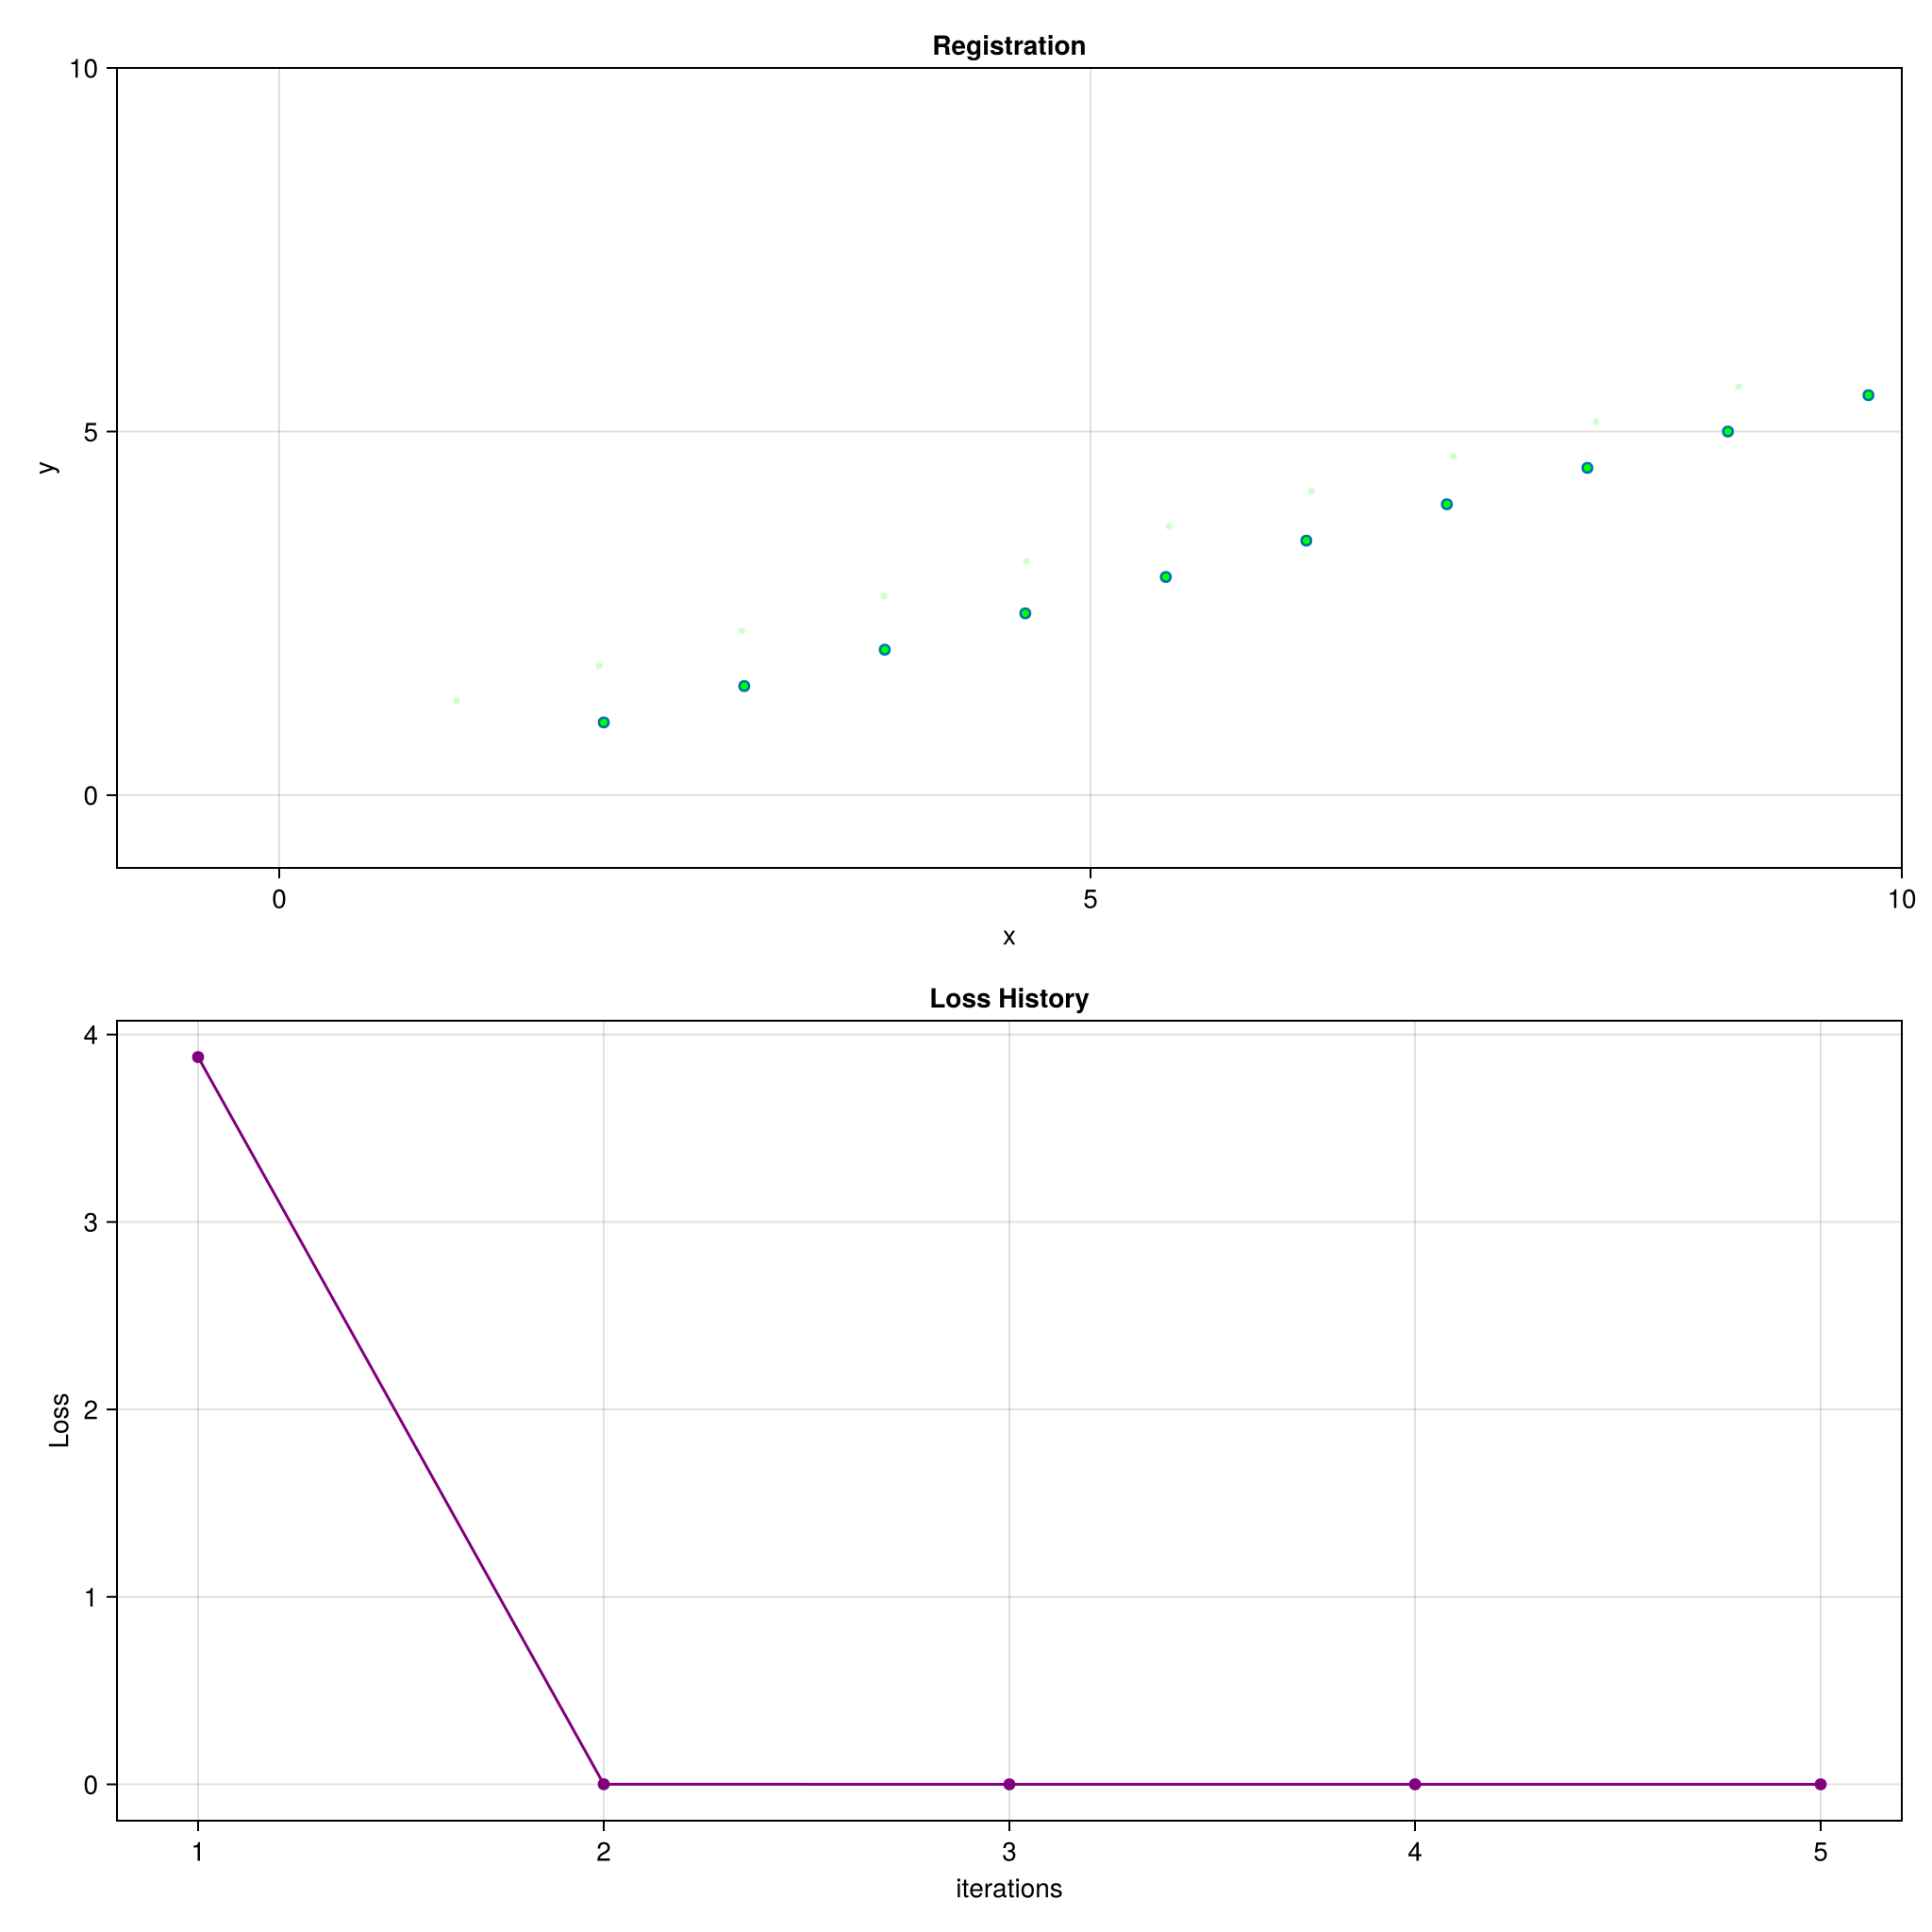

In [5]:
results = se2_registration_lm(x, y, Σs; λ0=0, iterations=5)

θ_GT_str = @sprintf("%.3f", rad2deg(θ_GT))
t_GT_str = "[" * join((@sprintf("%.3f", i) for i in t_GT), ", ") * "]"
θ_est_str = @sprintf("%.3f", rad2deg(get_rot(results.P_est)))
t_est_str = "[" * join((@sprintf("%.3f", i) for i in results.P_est[1:2,3]), ", ") * "]"
display(md"""
| Param | θ              | t              |
| ----- | -------------- | -------------- |
| GT    | $(θ_GT_str) °  | $(t_GT_str)    |
| Est   | $(θ_est_str) ° | $(t_est_str)   |
""")

f = Figure(;size=(1024, 1024))
ax = Axis(f[1,1], title="Registration", xlabel="x", ylabel="y")
scatter!(ax, y[1,:], y[2,:])
for (i, P) ∈ enumerate(results.history)
    x_est = P * x
    α = i / results.iterations
    scatter!(
        ax, 
        x_est[1,:], x_est[2,:],
        color=RGBA(0, 1, 0, α),
        markersize = 5
    )
end
xlims!(-1, 10)
ylims!(-1, 10)

ax = Axis(f[2,1], title="Loss History", xlabel="iterations", ylabel="Loss")
scatterlines!(ax, results.loss_history, color = :purple)
f